In [ ]:
import pandas as pd
import numpy as np
import re
import unicodedata
from google.colab import files


In [ ]:
uploaded = files.upload()

Saving ecommerce_furniture_dataset_2024.csv to ecommerce_furniture_dataset_2024.csv


In [ ]:
def parse_currency(x):
    """Convert messy currency strings to float"""
    if pd.isna(x): return np.nan
    s = str(x).strip()
    if not s or s.lower() in {"nan","none","null","na"}: return np.nan
    s = re.sub(r'[^\d\.,kKmM\-\+]', '', s)
    if ',' in s and '.' in s: s = s.replace(',', '')
    elif ',' in s and '.' not in s: s = s.replace(',', '')
    m = re.match(r'^([+\-]?\d+(\.\d+)?)([kKmM])?$', s)
    if m:
        num = float(m.group(1))
        suf = m.group(3)
        if suf:
            if suf.lower() == 'k': num *= 1000
            elif suf.lower() == 'm': num *= 1_000_000
        return num
    try: return float(s)
    except: return np.nan

def parse_sold(x):
    """Convert sold column to integer"""
    if pd.isna(x):
        return np.nan

    s = str(x).strip().lower().replace('+','').replace(' ','')

    # keep only digits, dot, minus, and k/m suffix
    s = re.sub(r'[^0-9.\-kKmM]', '', s)

    m = re.match(r'^([+\-]?\d+(\.\d+)?)([kKmM])?$', s)
    if m:
        num = float(m.group(1))
        suf = m.group(3)
        if suf:
            if suf.lower() == 'k': num *= 1000
            elif suf.lower() == 'm': num *= 1_000_000
        return int(round(num))

    try:
        return int(float(s))
    except:
        return np.nan

def clean_title(s):
    """Normalize productTitle"""
    if pd.isna(s): return ''
    t = str(s).strip()
    t = unicodedata.normalize('NFKD', t)
    t = re.sub(r'\s+', ' ', t)
    return t

In [ ]:
filename = list(uploaded.keys())[0]
df = pd.read_csv(filename, dtype=str)
print("Initial shape:", df.shape)
print(df.head())

Initial shape: (2000, 5)
                                        productTitle originalPrice    price  \
0  Dresser For Bedroom With 9 Fabric Drawers Ward...           NaN   $46.79   
1  Outdoor Conversation Set 4 Pieces Patio Furnit...           NaN  $169.72   
2  Desser For Bedroom With 7 Fabric Drawers Organ...         $78.4   $39.46   
3  Modern Accent Boucle Chair,Upholstered Tufted ...           NaN  $111.99   
4  Small Unit Simple Computer Desk Household Wood...        $48.82   $21.37   

  sold        tagText  
0  600  Free shipping  
1    0  Free shipping  
2    7  Free shipping  
3    0  Free shipping  
4    1  Free shipping  


In [ ]:
df['price'] = df['price'].apply(parse_currency)
df['originalPrice'] = df['originalPrice'].apply(parse_currency)
df['sold'] = df['sold'].apply(parse_sold)

df['productTitle'] = df['productTitle'].fillna('').apply(clean_title)
df['tagText'] = df['tagText'].fillna('').str.strip()

df['discount_percentage'] = np.where(
    df['originalPrice'].notna() & (df['originalPrice'] > 0),
    (df['originalPrice'] - df['price']) / df['originalPrice'] * 100,
    np.nan
)

top_tags = df['tagText'].value_counts().nlargest(10).index.tolist()
df['tagText_simple'] = df['tagText'].apply(lambda x: x if x in top_tags and x != '' else 'other')

df['price'] = pd.to_numeric(df['price'], errors='coerce')
df['originalPrice'] = pd.to_numeric(df['originalPrice'], errors='coerce')
df['sold'] = pd.to_numeric(df['sold'], errors='coerce').astype('Int64')

before = len(df)
df = df.drop_duplicates(subset=['productTitle', 'price'], keep='first').reset_index(drop=True)
after = len(df)
print(f"Dropped {before - after} duplicates. New shape: {df.shape}")

Dropped 102 duplicates. New shape: (1898, 7)


In [ ]:
print("\n--- Missing values ---")
print(df.isnull().sum())

print("\n--- Data types ---")
print(df.dtypes)

print("\n--- Price / Sold Summary ---")
print(df[['price','originalPrice','sold','discount_percentage']].describe())


--- Missing values ---
productTitle              0
originalPrice          1429
price                     0
sold                      0
tagText                   0
discount_percentage    1429
tagText_simple            0
dtype: int64

--- Data types ---
productTitle            object
originalPrice          float64
price                  float64
sold                     Int64
tagText                 object
discount_percentage    float64
tagText_simple          object
dtype: object

--- Price / Sold Summary ---
             price  originalPrice        sold  discount_percentage
count  1898.000000     469.000000      1898.0           469.000000
mean    153.886481     249.233945   24.537408            47.003667
std     176.642121     419.159014  260.792398            18.603055
min       0.990000       3.630000         0.0             0.000000
25%      47.315000      31.180000         1.0            41.410012
50%     111.910000      87.120000         3.0            48.188072
75%     191.28000

In [ ]:
df.to_csv("ecommerce_furniture_cleaned.csv", index=False)
print("\n✅ Cleaned dataset saved as ecommerce_furniture_cleaned.csv")


✅ Cleaned dataset saved as ecommerce_furniture_cleaned.csv


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

print(df.info())
print("\nSummary statistics:\n", df.describe(include='all'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1898 entries, 0 to 1897
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   productTitle         1898 non-null   object 
 1   originalPrice        469 non-null    float64
 2   price                1898 non-null   float64
 3   sold                 1898 non-null   Int64  
 4   tagText              1898 non-null   object 
 5   discount_percentage  469 non-null    float64
 6   tagText_simple       1898 non-null   object 
dtypes: Int64(1), float64(3), object(3)
memory usage: 105.8+ KB
None

Summary statistics:
                                              productTitle  originalPrice  \
count                                                1898     469.000000   
unique                                               1793            NaN   
top     Makeup Vanity Table Set Glass Top Makeup Vanit...            NaN   
freq                                             

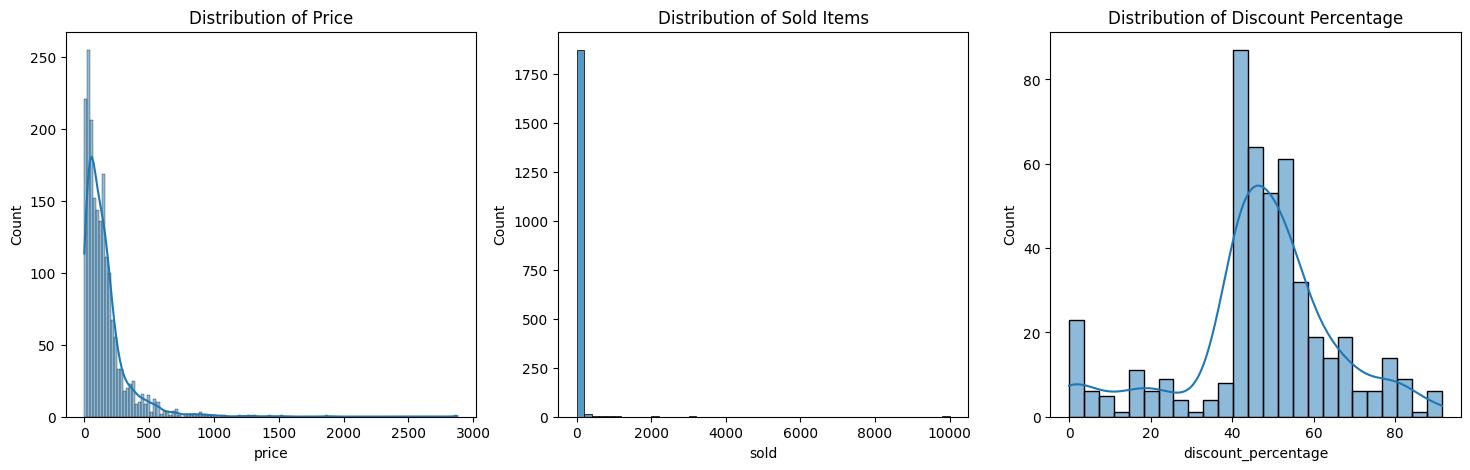

In [ ]:
# Distribution of numerical features
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(df['price'], kde=True, ax=axes[0])
axes[0].set_title("Distribution of Price")

sns.histplot(df['sold'], kde=False, bins=50, ax=axes[1])
axes[1].set_title("Distribution of Sold Items")

sns.histplot(df['discount_percentage'], kde=True, ax=axes[2])
axes[2].set_title("Distribution of Discount Percentage")

plt.show()

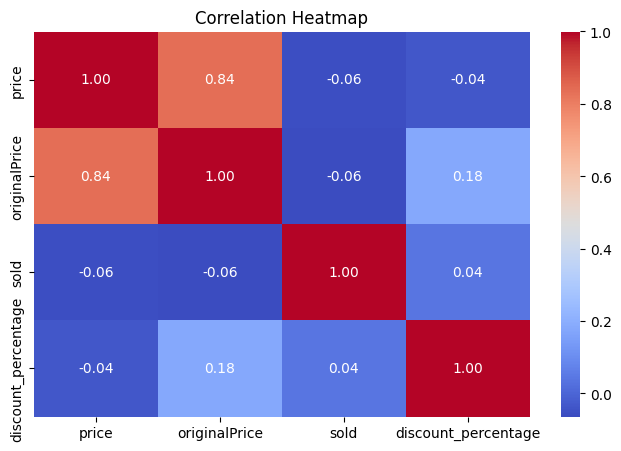

In [ ]:

# Correlation heatmap
plt.figure(figsize=(8,5))
sns.heatmap(df[['price','originalPrice','sold','discount_percentage']].corr(),
            annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

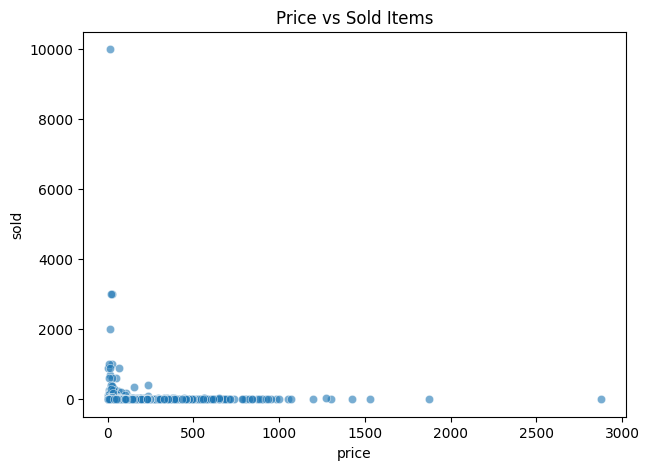

In [ ]:
# Price vs Sold (scatterplot)
plt.figure(figsize=(7,5))
sns.scatterplot(x='price', y='sold', data=df, alpha=0.6)
plt.title("Price vs Sold Items")
plt.show()

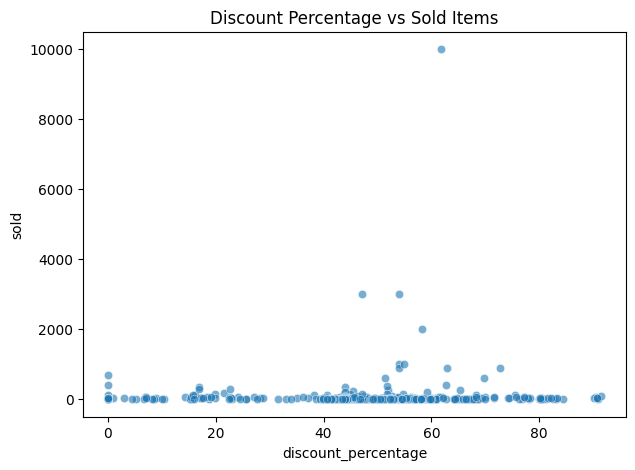

In [ ]:

# Discount vs Sold
plt.figure(figsize=(7,5))
sns.scatterplot(x='discount_percentage', y='sold', data=df, alpha=0.6)
plt.title("Discount Percentage vs Sold Items")
plt.show()

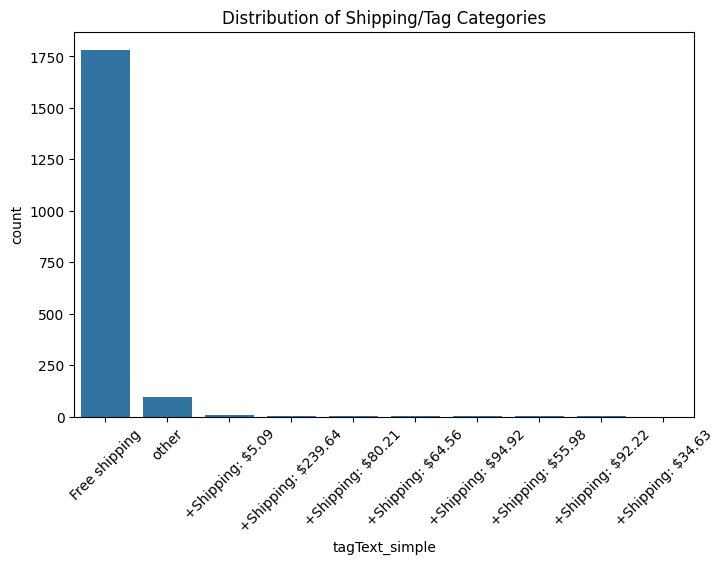

In [ ]:
# Categorical analysis (Tag distribution)
plt.figure(figsize=(8,5))
sns.countplot(x='tagText_simple', data=df, order=df['tagText_simple'].value_counts().index)
plt.title("Distribution of Shipping/Tag Categories")
plt.xticks(rotation=45)
plt.show()

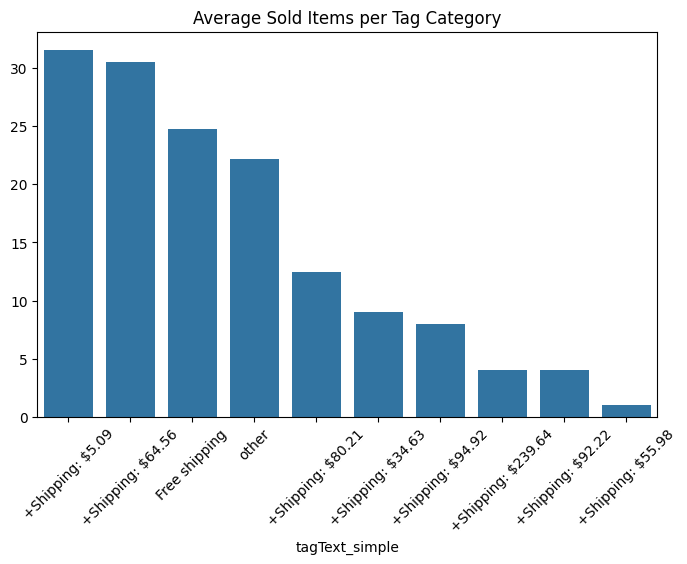

In [ ]:
# Average sales per tag
tag_sales = df.groupby('tagText_simple')['sold'].mean().sort_values(ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(x=tag_sales.index, y=tag_sales.values)
plt.title("Average Sold Items per Tag Category")
plt.xticks(rotation=45)
plt.show()

In [ ]:

# Top selling products
top_products = df[['productTitle','sold','price','tagText_simple']].sort_values(by='sold', ascending=False).head(10)
print("\n🏆 Top 10 Best-Selling Products:")
display(top_products)


🏆 Top 10 Best-Selling Products:


,productTitle,sold,price,tagText_simple
968,Portable round Folding Chair Accordion Chair H...,10000,12.28,Free shipping
1349,MUMUCC Multifunctional Foldable And Adjustable...,3000,21.94,Free shipping
659,MUMUCC Multifunctional Foldable And Adjustable...,3000,26.11,Free shipping
981,Stylish Shoe Rack Metal Simple Shoe Shelf Foot...,2000,13.64,Free shipping
1133,Portability Foot Rest Under Desk Footrest Ergo...,1000,8.04,Free shipping
22,Office Furniture Computer Stand 42*26cm Adjust...,1000,26.03,Free shipping
1467,Portable Folding Telescopic Stool Lightweight ...,900,11.20,Free shipping
656,Portability Foot Rest Under Desk Footrest Ergo...,900,5.00,Free shipping
976,"Monitor Stand for 13-32 inches Screens, Dual M...",900,66.68,Free shipping
463,Shoe-shelf Shoerack Multilayer Shoe Rack Shoeb...,700,15.40,Free shipping


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import numpy as np

# Log-transform target (helps with skewness)
df['sold_log'] = np.log1p(df['sold'])

# Define feature columns
X = df[['productTitle','price','discount_percentage','tagText_simple']]
y = df['sold_log']

# Column types
text_features = ['productTitle']
numeric_features = ['price','discount_percentage']
cat_features = ['tagText_simple']

# Preprocessing pipeline with Imputers
preprocessor = ColumnTransformer(
    transformers=[
        # Text features → TF-IDF
        ('title_tfidf', TfidfVectorizer(max_features=100, stop_words='english'), 'productTitle'),

        # Numeric features → Impute missing with median → Scale
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),

        # Categorical features → Impute missing with most_frequent → OneHotEncode
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), cat_features)
    ]
)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("✅ Data ready:", X_train.shape, "train samples,", X_test.shape, "test samples")


✅ Data ready: (1518, 4) train samples, (380, 4) test samples


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from xgboost import XGBRegressor
from math import sqrt

# Model 1: Linear Regression
lr_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# Model 2: Random Forest
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=200,
        random_state=42,
        max_depth=None,
        min_samples_split=2
    ))
])

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Model 3: XGBoost
xgb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        objective='reg:squarederror'
    ))
])

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Function to evaluate models
def evaluate_model(y_true, y_pred, name):
    r2 = r2_score(y_true, y_pred)
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    print(f"📊 {name} Results:")
    print(f"   R² Score: {r2:.4f}")
    print(f"   RMSE: {rmse:.4f}")
    print("-"*35)

# Evaluation
evaluate_model(y_test, y_pred_lr, "Linear Regression")
evaluate_model(y_test, y_pred_rf, "Random Forest Regressor")
evaluate_model(y_test, y_pred_xgb, "XGBoost Regressor")

📊 Linear Regression Results:
   R² Score: 0.1533
   RMSE: 1.3088
-----------------------------------
📊 Random Forest Regressor Results:
   R² Score: 0.3287
   RMSE: 1.1654
-----------------------------------
📊 XGBoost Regressor Results:
   R² Score: 0.2982
   RMSE: 1.1916
-----------------------------------


# ===============================
# 📌 Phase 5: Hyperparameter Tuning
# ===============================

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Random Forest Tuning
rf_param_grid = {
    'regressor__n_estimators': [100, 200, 300, 500],
    'regressor__max_depth': [None, 5, 10, 20],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

rf_grid_search = RandomizedSearchCV(
    estimator=Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(random_state=42))
    ]),
    param_distributions=rf_param_grid,
    n_iter=20,
    cv=3,
    scoring='r2',
    verbose=2,
    random_state=42,
    n_jobs=-1
)

rf_grid_search.fit(X_train, y_train)
print("\n✅ Best Random Forest Params:")
print(rf_grid_search.best_params_)
print("Best R² Score:", rf_grid_search.best_score_)

# Store the best Random Forest model
best_rf_model = rf_grid_search.best_estimator_

#  XGBoost Tuning
xgb_param_grid = {
    'regressor__n_estimators': [100, 200, 300, 500],
    'regressor__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'regressor__max_depth': [3, 5, 7, 9],
    'regressor__subsample': [0.6, 0.8, 1.0],
    'regressor__colsample_bytree': [0.6, 0.8, 1.0]
}

xgb_search = RandomizedSearchCV(
    estimator=Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', XGBRegressor(random_state=42, objective='reg:squarederror'))
    ]),
    param_distributions=xgb_param_grid,
    n_iter=20,
    cv=3,
    scoring='r2',
    verbose=2,
    random_state=42,
    n_jobs=-1
)

xgb_search.fit(X_train, y_train)
print("\n✅ Best XGBoost Params:")
print(xgb_search.best_params_)
print("Best R² Score:", xgb_search.best_score_)

# Store the best XGBoost model
best_xgb_model = xgb_search.best_estimator_

Fitting 3 folds for each of 20 candidates, totalling 60 fits

✅ Best Random Forest Params:
{'regressor__n_estimators': 300, 'regressor__min_samples_split': 5, 'regressor__min_samples_leaf': 1, 'regressor__max_depth': 10}
Best R² Score: 0.30860654422448064
Fitting 3 folds for each of 20 candidates, totalling 60 fits

✅ Best XGBoost Params:
{'regressor__subsample': 0.6, 'regressor__n_estimators': 300, 'regressor__max_depth': 5, 'regressor__learning_rate': 0.01, 'regressor__colsample_bytree': 1.0}
Best R² Score: 0.3175286451975505


In [ ]:
import joblib

# Save the tuned XGBoost model pipeline
joblib.dump(best_xgb_model, "best_xgboost_model.pkl")

# If you want to also save Random Forest:
joblib.dump(best_rf_model, "best_random_forest_model.pkl")

print("✅ Models saved successfully!")

✅ Models saved successfully!
